# Value at Risk (VaR) by MonteCarlo method in Stock Portfolio by clustering and ML algorithm for forecasting prices

#### It is important to know that I will speak in the 3rd person as if I was presenting in a forum

## Importing the libraries we will use

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

## Variables for the stock downloader

In [4]:
years = 12
today = date.today()
start = today.replace(year=today.year - years)

## The composite and stock list we will use

In [5]:
composite = '^IXIC' #Nasdaq composite
csv = pd.read_csv('stock.csv') #Nasdaq stocks
stockList = csv['Stock'].tolist()

## Downloading the prices from yahoo finance

In [6]:
stockPrice = yf.download(stockList, start=start, end=today, interval='1d')['Adj Close']
stockPrice['Composite'] = yf.download(composite, start=start, end=today, interval='1d')['Adj Close']

[*********************100%***********************]  102 of 102 completed
[*********************100%***********************]  1 of 1 completed


## The null data % is higher
### The thing in stock prices is, null prices are very common owing to closures in the market or holidays
### We need to fill those null prices

In [7]:
f"{stockPrice.isna().values.sum() / len(stockPrice):.2%}"

'1003.74%'

## We will fill by forwardfill method if the previous price exists
### If not, it means the previous price does not exists. The price will be 0 (it means the stock is new)

In [8]:
stockPrice = stockPrice.fillna(method='ffill')
stockPrice = stockPrice.fillna(0)

## Here we have the top 5 companies in Nasdaq

<AxesSubplot:xlabel='Date'>

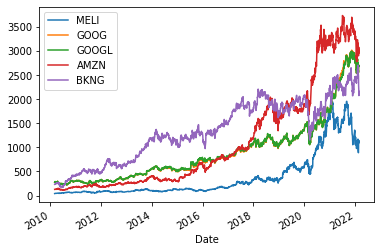

In [9]:
stockPrice[((stockPrice[stockList].mean()).sort_values(axis=0)[-5:]).index].plot()

## Beta and Return calculator

### We will create the beta and return column for each stock
### Then, the composite row will be dropped for clustering method

In [10]:
returns = stockPrice.pct_change()
reu = returns.fillna(0)
reu = reu.replace(np.inf, 0)
reu = reu.mean()
beta = (returns.cov()['Composite'])/(returns['Composite'].var())
stockSummary = pd.concat([beta, reu], axis=1)
stockSummary = stockSummary.rename(columns={'Composite': 'Beta',0: 'Returns'})
composite_summary = stockSummary.loc['Composite']
stockSummary = stockSummary.drop(['Composite'], axis=0)
stockSummary = stockSummary.dropna(axis=0)

## Clustering by K-Means (Elbow method)
### We will plot the clusters and the centroids

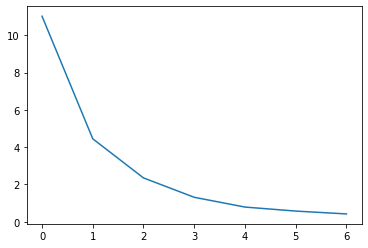

In [11]:
z = 8
wcss = []
for i in range(1, z):
    kmeans = KMeans(n_clusters=i, max_iter=300)
    kmeans.fit(stockSummary)
    wcss.append(kmeans.inertia_)  
clustering = KMeans(n_clusters=z, max_iter=300)
clustering.fit(stockSummary)
stockSummary['Clusters'] = clustering.labels_
plt.plot(wcss)
plt.show()

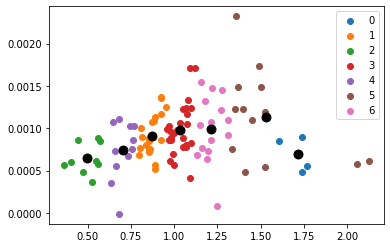

In [12]:
label = kmeans.fit_predict(stockSummary)
centroids = kmeans.cluster_centers_
uniqueLabels = np.unique(label)
 
for i in uniqueLabels:
    plt.scatter(stockSummary.iloc[label==i, 0], stockSummary.iloc[label==i ,1], label=i)
plt.scatter(centroids[:,0], centroids[:,1], s=80, color='black')
plt.legend()
plt.show()

## Summary of each cluster
### If beta > 1, means the stock has volatility. The profit will be higher
### If beta < 1, means the stock is so secure. The profit will be lower

### Now, we need to choose some cluster

In [13]:
means = stockSummary.groupby('Clusters').mean()
means

,Beta,Returns
Clusters,,
0,0.702792,0.000741
1,1.713799,0.000694
2,1.215727,0.000993
3,1.033963,0.000981
4,0.494693,0.000645
5,1.427950,0.001231
6,2.091762,0.000592
7,0.870318,0.000914


In [14]:
stockSummary['Clusters'].value_counts()

3    27
7    23
2    15
5    11
0    11
4     9
1     4
6     2
Name: Clusters, dtype: int64

## The cluster selected
### We choosed the portfolio with the biggest Return in the box
### We will use a confidence interval of 30% for choose the best portfolio
### Also, we will use only the stocks which beta and return values are higher than mean - standard desviation 
### In case the portfolio list had more than five tickers, the random will choose only five

In [72]:
higherReturn = ((stockSummary.groupby('Clusters').mean())['Returns'].sort_values()[1:]).index[0]
selectedCluster = stockSummary[stockSummary['Clusters'] == higherReturn]
confidenceInterval = 0.3
portfolio = selectedCluster[selectedCluster['Returns'] > (selectedCluster.mean()['Returns'] - (selectedCluster.std()['Returns']))]
portfolioTicker = (portfolio.index).tolist()
portfolioTicker = np.random.choice(portfolioTicker, 5, replace=False)
portfolioTicker

array(['MDLZ', 'AZN', 'KDP', 'COST', 'PEP'], dtype='<U4')

## Here we have the portfolio's yield

<AxesSubplot:xlabel='Date'>

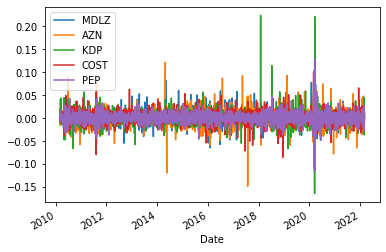

In [73]:
portfolioReturn = (stockPrice[portfolioTicker].pct_change()).dropna()
portfolioReturn = portfolioReturn.replace(np.inf, 0)
lastPrice = stockPrice[portfolioTicker].iloc[-1]
portfolioReturn.plot()

## The portfolio has a normal distribution
### In the long term, thanks to the Central Limit Theorem, all the paths they may take will fulfill the CLT 

<AxesSubplot:ylabel='Density'>

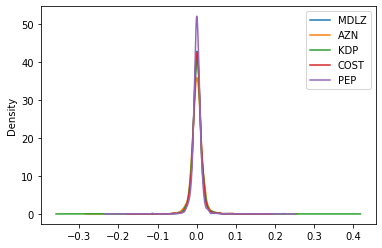

In [74]:
portfolioDensity = portfolioReturn.plot.kde()
portfolioDensity

## VaR by MonteCarlo
### To know the maximum loss, we will use the Value at Risk by MonteCarlo method
### We need to create some matrix
### First of all, the weight of each stock in the portfolio
### Then, the mean matrix and simulation matrix (we will use 10,000 simulations with a time frame of 100)
### For the zFactor we will use the normal distribution thanks to the CLT
### The Cholesky descomposition is used to transform independen variables to correlated variables in matrix
### After that, we need to create a matrix based of Geometrical Brownian Motion with zFactor, Choslesky, the daily returns and our capital

In [75]:
def monte_carlo(returns, tickers, simulations=10000, capital=10000, t=100):
    weights = np.random.random(len(tickers)) #the weigth of each stock in the portfolio, the sum will be 1
    weights /= np.sum(weights)
    meanMatrix = (np.full(shape=(t, len(tickers)), fill_value=returns.mean())).T
    portfolioSimulations = np.full(shape=(t, simulations), fill_value=0)
    for i in range(0, simulations):
        zFactor = np.random.normal(size=(t, len(tickers)))
        Cholesky = np.linalg.cholesky(returns.cov())
        dailyReturns = meanMatrix + np.inner(Cholesky, zFactor)
        portfolioSimulations[:, i] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*capital
    return portfolioSimulations

## This is the VaR by MonteCarlo
### There are all the ways the portfolio may take

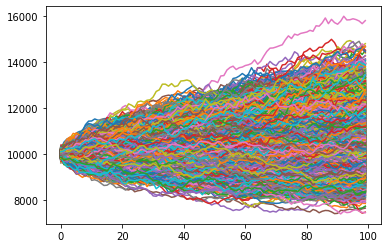

In [76]:
monteCarlo = monte_carlo(portfolioReturn, portfolioTicker)
plt.plot(monteCarlo)
plt.show()

## Our maximum loss
### Thanks to the VaR, now we can know our maximum loss
### We have the 5% of probability to loss the VaR
### If our portfolio goes below, the maximum loss will be CVaR

In [77]:
def VaR(returns, capital=10000, confidence_interval=95):
    VaR = capital - np.percentile(returns, 100-confidence_interval)
    CVaR = capital - returns[returns <= np.percentile(returns, 100-confidence_interval)].mean()
    print('VaR ${}'.format(round(VaR, 2)))
    print('CVaR ${}'.format(round(CVaR, 2)))
VaRReturns = monteCarlo[-1,:]
portfolioVaR = VaR(VaRReturns)

VaR $900.05
CVaR $1247.03


## Historical price
### We can observe our portfolio at n years

<AxesSubplot:xlabel='Date'>

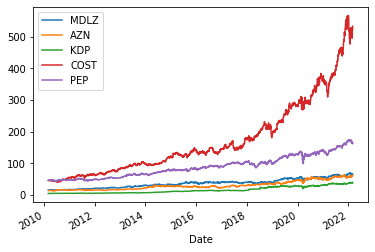

In [78]:
stockPrice[portfolioTicker].plot()

## Variance
### The variance is important thanks to the fact it represents how correlated are our stocks
### Lower variance means our portfolio is less correlated

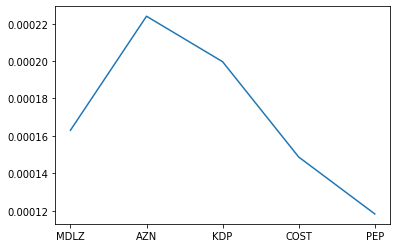

In [79]:
plt.plot(portfolioReturn.var())
plt.show()

## Forecast and Feature Scaling

### For the forecast we gonna use LSTM's because they are really good to learn sequences and have proven to be extremely effective.
### The reason they work so well is that LSTM can store past important information and forget the information that is not.

### First of all, we need to choose the data for train. We gonna use 20% of the data.
### After that, we will normalize the data with the Min Max Scaler

### Then we gonna create the x and y arrays for the training.
### Also, the implementation of LSTM and the fit will be quickly

### We will test the x and y arrays for the model prediction
### We gonna create the train data frame for the final data frame which is called valid

### In the last dataframe, we gonna have the original price and the forecasted price

In [92]:
def forecasting(stockValues, stockTicker):
    data = stockValues.values
    dataLenght = round(len(data)*.8)#80% of the data
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)
    
    trainData = scaledData[0:dataLenght, :]
    xTrain, yTrain = [], [] 
    for i in range(60, len(trainData)):
        xTrain.append(trainData[i-60:i, 0])
        yTrain.append(trainData[i, 0])
    xTrain, yTrain = np.array(xTrain), np.array(yTrain)
    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
   
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(xTrain.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(xTrain, yTrain, batch_size=1, epochs=1)
    
    testData = scaledData[dataLenght - 60:,:]
    xTest, yTest = [], data[dataLenght:,:] 
    for i in range(60, len(testData)):
        xTest.append(testData[i-60:i, 0])
    xTest = np.array(xTest)
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))
    
    forecasting = model.predict(xTest)
    forecasting = scaler.inverse_transform(forecasting)
   
    #The rmse and the train works better if the function does not exist haha
    
    #rmse = np.sqrt(np.mean(forecasting-yTest)**2)
    
    train = data[:dataLenght]
    
    valid = pd.DataFrame(data[dataLenght:], columns=['Original {}'.format(stockTicker)])
    valid['Forecast {}'.format(stockTicker)] = forecasting
    
    return valid

## Forecasting the portfolio
### Here we will create the forecast for each stock
### Also, we gonna concatenate the results into a dataframe

In [100]:
forec = []
for i in range(0, len(portfolioTicker)):
    print(portfolioTicker[i:i+1][0])
    vars()[portfolioTicker[i:i+1][0]] = forecasting(stockPrice[portfolioTicker[i:i+1]], portfolioTicker[i:i+1][0])
    forec.append(vars()[portfolioTicker[i:i+1][0]])  
forecast = pd.concat(forec, axis=1)
forecast.head()

MDLZ
2358/2358 [==============================] - 42s 16ms/step - loss: 7.3757e-04
AZN
2358/2358 [==============================] - 46s 18ms/step - loss: 6.0188e-04
KDP
2358/2358 [==============================] - 44s 17ms/step - loss: 5.0839e-04
COST
2358/2358 [==============================] - 43s 17ms/step - loss: 2.6229e-04
PEP
2358/2358 [==============================] - 46s 18ms/step - loss: 4.6347e-04


,Original MDLZ,Forecast MDLZ,Original AZN,Forecast AZN,Original KDP,Forecast KDP,Original COST,Forecast COST,Original PEP,Forecast PEP
0,52.744389,52.608089,40.584766,41.341213,26.365969,26.570942,283.894836,277.701385,128.431717,125.633713
1,52.182766,52.673637,40.566154,41.359478,26.528131,26.624510,284.334290,278.892700,128.198868,125.740181
2,51.611637,52.669865,40.808170,41.404800,26.137033,26.716614,284.257874,280.047577,128.021927,125.784210
3,51.440292,52.554344,41.152576,41.493134,26.261044,26.761890,285.089172,281.054932,126.978722,125.773613
4,51.659222,52.386547,40.761631,41.638329,26.337351,26.797913,285.461792,281.969055,127.062546,125.621758


## Portfolio Forecasted
### There is the real portfolio agaisnt the forecasted

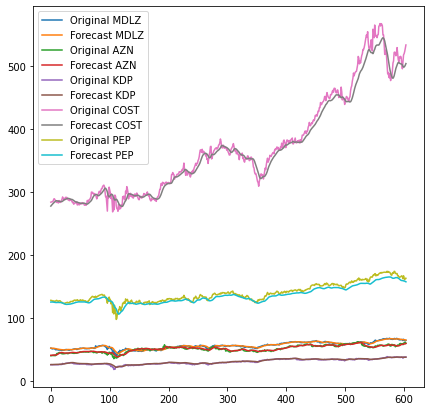

In [101]:
plt.figure(figsize=(7,7))
plt.plot(forecast)
plt.legend(forecast.columns)
plt.show()

## VaR for forecasted portfolio
### Now is time to know  how bigger or smaller will be the maximum loss with the forecasting

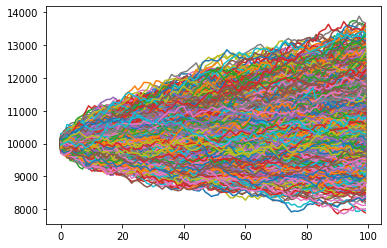

In [143]:
data = stockPrice[portfolioTicker]
dataLenght = round(len(data)*.8)#80% of the data
originalData = data[:dataLenght].loc[:, ::-1]
forecastedData = forecast.loc[:, ::-2]
originalData.columns = forecastedData.columns
forecastedReturn = pd.concat([originalData, forecastedData]).pct_change().dropna()
forecastedMonteC = monte_carlo(forecastedReturn, portfolioTicker)

plt.plot(forecastedMonteC)
plt.show()

### Now we know the forecasted portfolio has a higher lost ratio

In [144]:
forecastedVaRRet = forecastedMonteC[-1,:]
forecastedVaR = VaR(forecastedVaRRet)

VaR $591.05
CVaR $882.57
